In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
# nltk.download('stopwords')
# nltk.download('wordnet')


## Train and test dataset

In [2]:
col_names=["tweet id","entity","sentiment","tweet content"]
df = pd.read_csv("./twitter_training.csv",names=col_names,header=None)
df.head()

,tweet id,entity,sentiment,tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
df_val = pd.read_csv("./twitter_validation.csv",names=col_names,header=None)
df_val.head()

,tweet id,entity,sentiment,tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [4]:
df.isna().sum()

tweet id           0
entity             0
sentiment          0
tweet content    686
dtype: int64

In [5]:
df = df.dropna()
df.isnull().sum()

tweet id         0
entity           0
sentiment        0
tweet content    0
dtype: int64

In [6]:
df_duplicated = df.duplicated().sum()
print(f"There are {df_duplicated} duplicate values in the dataset")

There are 2340 duplicate values in the dataset


In [7]:
df = df.drop_duplicates()
df_remove_duplicated = df.duplicated().sum()
print(f"There are {df_remove_duplicated} duplicate values in the dataset")

There are 0 duplicate values in the dataset


## Removing outliers

[Text(0.5, 1.0, 'Distribution of tweet content length')]

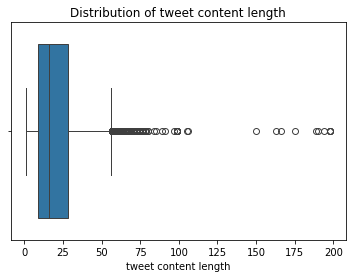

In [8]:
df["tweet content length"] = df["tweet content"].map(lambda x:len(x.split(" ")))
sns.boxplot(x="tweet content length",data=df).set(title='Distribution of tweet content length')

In [9]:
lower_quartile = np.percentile(df["tweet content length"],25) #Calculating lower_quartile
median = np.percentile(df["tweet content length"],50) #Calculating median
upper_quartile = np.percentile(df["tweet content length"],75) #Calculating upper_quartile

interquartile_range = upper_quartile - lower_quartile #Calculating interquartile_range(IQR)
lower_boundary = lower_quartile - 1.5*interquartile_range #Calculating lower_boundary
upper_boundary = upper_quartile + 1.5*interquartile_range #Calculating upper_boundary

#tweet content length smaller than lower_boundary or larger than upper_boundary will be removed
print("lower_boundary:",lower_boundary)
print("upper_boundary:",upper_boundary)

lower_boundary: -19.5
upper_boundary: 56.5


In [10]:
#Remove outliers
removed_df = df[(df["tweet content length"]>=lower_boundary)&(df["tweet content length"]<=upper_boundary)]

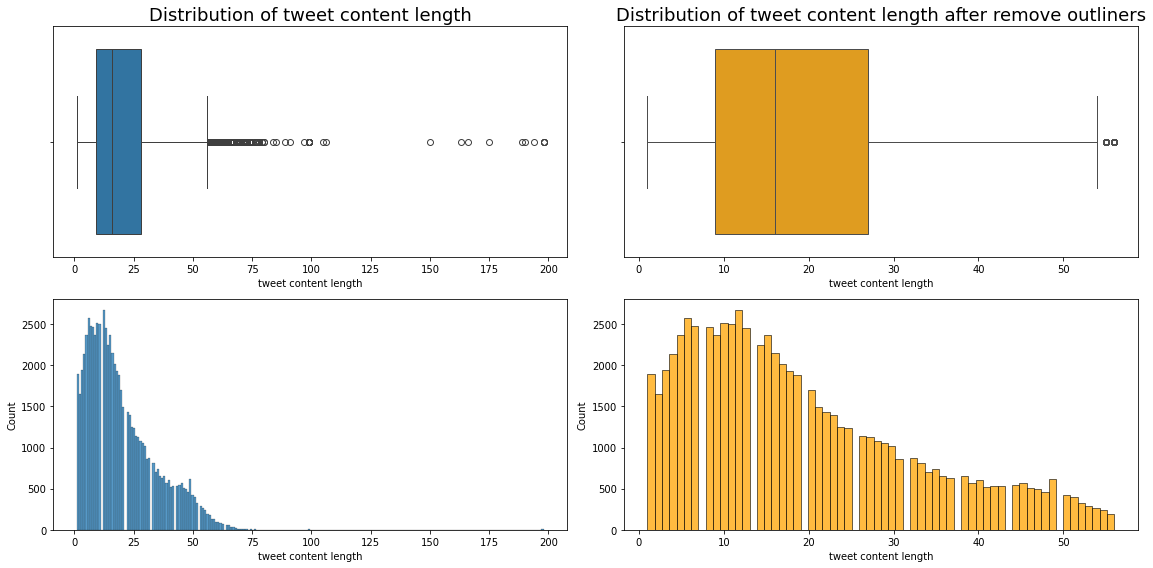

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

#distribution of tweet content length
sns.boxplot(x="tweet content length",data=df,ax=ax[0,0]).set_title("Distribution of tweet content length",fontsize=18)
sns.boxplot(x="tweet content length",data=removed_df,ax=ax[0,1],color="orange").set_title("Distribution of tweet content length after remove outliners",fontsize=18)

#frequency of tweet content length
sns.histplot(x="tweet content length",data=df,ax=ax[1,0])
sns.histplot(x="tweet content length",data=removed_df,ax=ax[1,1],color="orange")

fig.tight_layout()

<Axes: xlabel='sentiment', ylabel='count'>

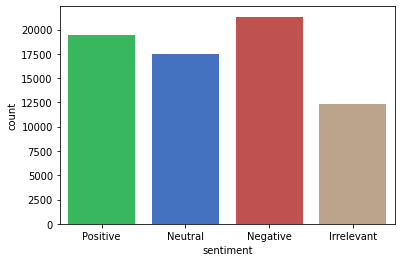

In [12]:
sentiment_list=["Positive","Neutral","Negative","Irrelevant"]
colors = ['#23cc55', '#316cd4', '#d13f3f','#C4A484']
sns.countplot(x="sentiment",data=removed_df,palette=colors,hue="sentiment")

# WordCloud 

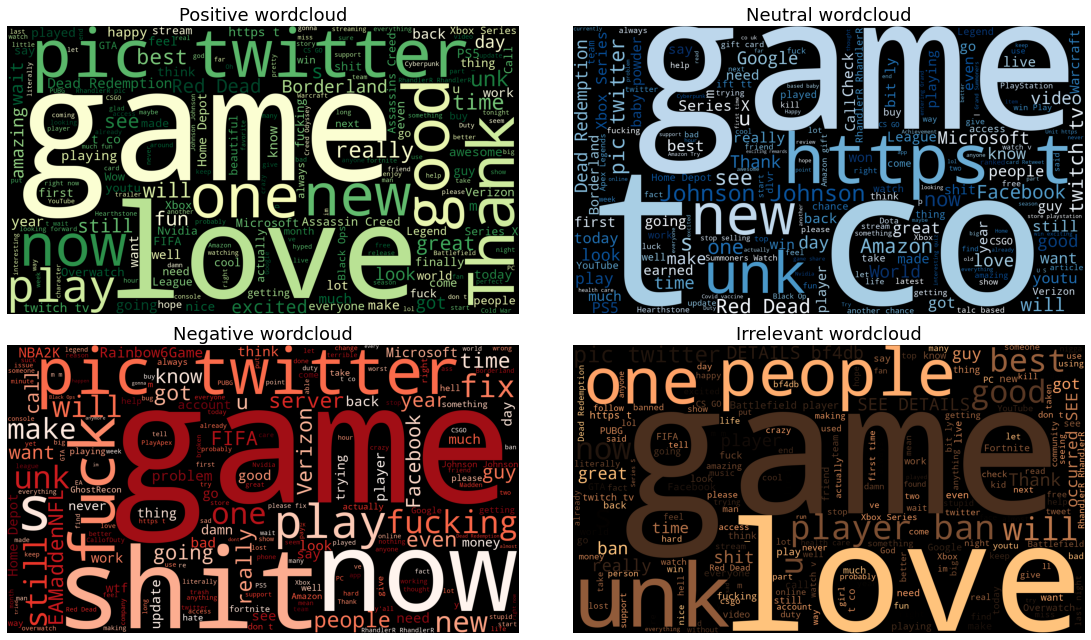

In [13]:
colormap_list=["YlGn_r","Blues_r","Reds_r","copper_r"]
ax_list = [[0,0],[0,1],[1,0],[1,1]]
stopwords_set = set(STOPWORDS)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
for sentiment,(row,col),colormap in zip(sentiment_list,ax_list,colormap_list):

    #Create wordcloud for each sentiment
    text = " ".join(content for content in removed_df[removed_df["sentiment"]==sentiment]["tweet content"])
    wordcloud = WordCloud(colormap=colormap, stopwords=stopwords_set, width=1600, height=900).generate(text)

    #Plot wordcloud
    ax[row,col].imshow(wordcloud)
    ax[row,col].set_title(sentiment+" wordcloud", fontsize=18)
    ax[row,col].axis('off')

fig.tight_layout()

## Frequency of entity 

Text(0.5, 1.0, 'Frequency of entity')

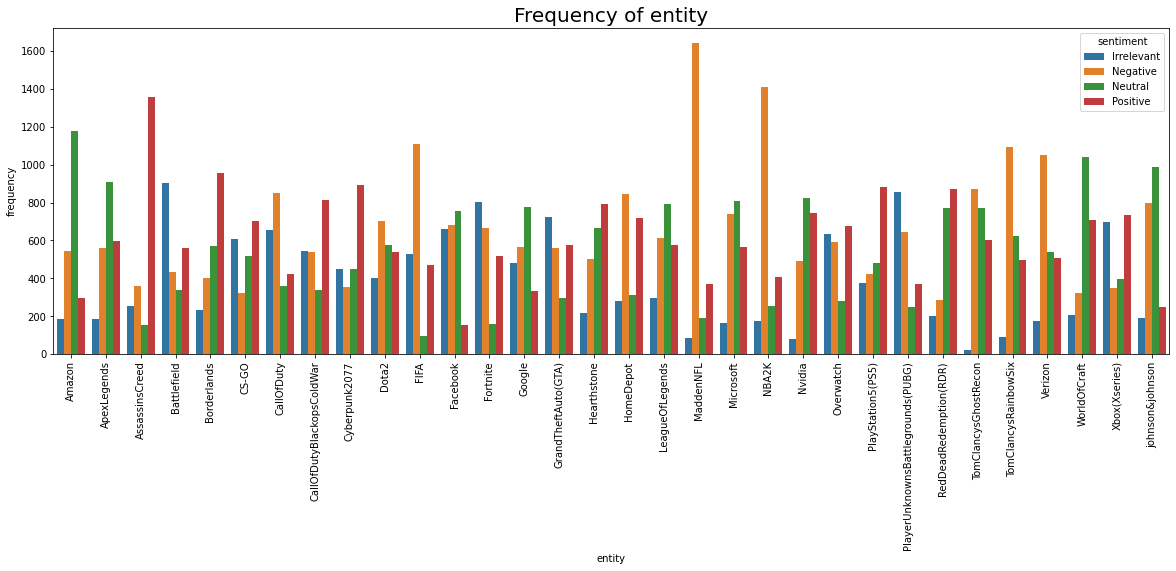

In [14]:
entity_frequency = removed_df.groupby(["sentiment","entity"]).size().reset_index()
entity_frequency.rename(columns={0: 'frequency'}, inplace=True)

plt.figure(figsize=(20,6))
plt.xticks(rotation=90)
sns.barplot(data=entity_frequency,x="entity",y="frequency",hue="sentiment").set_title("Frequency of entity", fontsize=20)

In [15]:
x_train = removed_df["entity"] + " " + removed_df["tweet content"]
y_train = removed_df["sentiment"]
x_test = df_val["entity"] + " " + df_val["tweet content"]
y_test = df_val["sentiment"]

## Text preprocessing 

In [16]:
# function turns pos_tag into wordnet_pos
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [17]:

def text_preprocessing(text):

    #tokenize
    text_tokenize = word_tokenize(text)

    #split text and entity
    entity = text_tokenize[0]
    text_content = text_tokenize[1:]

    #pos tagging
    text_pos = pos_tag(text_content)

    #remove punctuation and stopwords
    remove_words = set(list(string.punctuation) + stopwords.words('english'))
    text_remove = [(word,pos) for (word,pos) in text_pos if word not in remove_words]

    #lemmaization
    word_lem = WordNetLemmatizer()
    text_lem = [(word_lem.lemmatize(word,pos=get_wordnet_pos(pos)),pos) if get_wordnet_pos(pos) != None
                 else (word_lem.lemmatize(word),pos) for (word,pos) in text_remove]

    #combine text and entity
    text_lem.append((entity,))

    return text_lem

In [18]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [19]:
#test text_preprocessing
example_text = "Overwatch Overwatch is a wonderful game, even after so many years."
print("Original sentence: ", example_text)
print("After text_preprocessing: ", text_preprocessing(example_text))

Original sentence:  Overwatch Overwatch is a wonderful game, even after so many years.
After text_preprocessing:  [('Overwatch', 'NN'), ('wonderful', 'JJ'), ('game', 'NN'), ('even', 'RB'), ('many', 'JJ'), ('year', 'NNS'), ('Overwatch',)]


In [20]:
#Combine text_preprocessing, CountVectorizer and TfidfTransformer into pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_preprocessing)),
    ('tfidf', TfidfTransformer())
])

#Apply pipeline to x_train and x_test
x_train_processed = pipeline.fit_transform(x_train)
x_test_processed = pipeline.transform(x_test)

In [21]:
classifier_accuracy=[]

## Convolutional Neural Network

In [22]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import History

max_words = 5000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

max_sequence_length = 300
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length)
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_sequence_length)


model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=50, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=len(sentiment_list), activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = History()

history=model.fit(x_train_padded, pd.get_dummies(y_train), epochs=5, batch_size=32)
train_accuracy = history.history['accuracy']

accuracy = model.evaluate(x_test_padded, pd.get_dummies(y_test))[1]
print(f"Test Accuracy: {accuracy}")
classifier_accuracy.append([' 1D Convolutional Neural Network',accuracy,train_accuracy[4]])

Epoch 1/5
2206/2206 [==============================] - 33s 15ms/step - loss: 0.8405 - accuracy: 0.6617
Epoch 2/5
2206/2206 [==============================] - 33s 15ms/step - loss: 0.3983 - accuracy: 0.8556
Epoch 3/5
2206/2206 [==============================] - 33s 15ms/step - loss: 0.2233 - accuracy: 0.9203
Epoch 4/5
2206/2206 [==============================] - 36s 16ms/step - loss: 0.1580 - accuracy: 0.9423
Epoch 5/5
32/32 [==============================] - 0s 5ms/step - loss: 0.2143 - accuracy: 0.9570
Test Accuracy: 0.9570000171661377


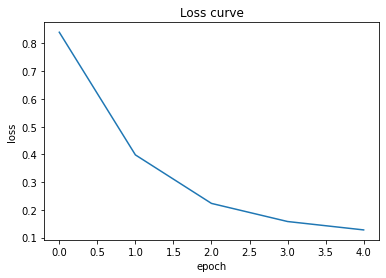

In [23]:
plt.plot(history.history['loss'])
plt.title('Loss curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Grid search 

In [28]:
from sklearn.model_selection import GridSearchCV

classifiers = [
    {
        'name': 'Logistic Regression',
        'classifier': LogisticRegression(),
        'params': {
            'solver' : ['lbfgs','liblinear', 'saga'],
            'C': [0.1, 1, 10],
            'max_iter': [10000]
        }
    },
    {
        'name': 'KNeighborsClassifier',
        'classifier': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 10]
        }
    },
    {
        'name': 'DecisionTreeClassifier',
        'classifier': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    },
]

for clf in classifiers:
    grid_search = GridSearchCV(clf['classifier'], clf['params'], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(x_train_processed, y_train)

    best_params = grid_search.best_params_

    print(f"Best parameters for {clf['name']}: {best_params}")

Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 10000, 'solver': 'liblinear'}
Best parameters for KNeighborsClassifier: {'n_neighbors': 5}
Best parameters for DecisionTreeClassifier: {'max_depth': None, 'min_samples_split': 10}


## Randomized search 

In [29]:
from sklearn.model_selection import RandomizedSearchCV

classifiers = [
    {
        'name': 'RandomForestClassifier',
        'classifier': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
        }
    },
    {
        'name': 'SVC',
        'classifier': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    }
]

for clf in classifiers:
    random_search = RandomizedSearchCV(clf['classifier'], clf['params'],scoring='accuracy',n_iter=5, cv=5, n_jobs=-1, random_state=42)
    random_search.fit(x_train_processed, y_train)

    best_params = random_search.best_params_

    print(f"Best parameters for {clf['name']}: {best_params}")

Best parameters for RandomForestClassifier: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}
Best parameters for SVC: {'kernel': 'linear', 'C': 0.1}


## Sklearn classifiers 

In [24]:
classifier_used = [
    MultinomialNB(),
    LogisticRegression(C=0.1, max_iter= 10000, solver= 'liblinear'),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(max_depth=None,min_samples_split=10),
    RandomForestClassifier(n_estimators=200, min_samples_split=10, max_depth=None),
    SVC(kernel='linear', C=0.1),
]

In [25]:

confusion_matrix_displays = {}
for classifier in classifier_used:
    fit = classifier.fit(x_train_processed, y_train)
    predict = fit.predict(x_test_processed)
    trainset_predict = fit.predict(x_train_processed)
    print('Classification report for classifier {} : '.format(classifier))
    print('*****************************************************************************')
    print(classification_report(y_test,predict))
    print('*****************************************************************************\n')
    confusion_matrix_displays[classifier.__class__.__name__] = {'classifier': fit, 'predict': predict, 'trainset_predict': trainset_predict}
    accuracy = accuracy_score(predict,y_test)
    trainset_accuracy = accuracy_score(trainset_predict,y_train)
    classifier_accuracy.append([classifier.__class__.__name__,accuracy,trainset_accuracy])

Classification report for classifier MultinomialNB() : 
*****************************************************************************
              precision    recall  f1-score   support

  Irrelevant       1.00      0.68      0.81       172
    Negative       0.73      0.95      0.82       266
     Neutral       0.95      0.73      0.83       285
    Positive       0.82      0.94      0.88       277

    accuracy                           0.84      1000
   macro avg       0.87      0.82      0.83      1000
weighted avg       0.86      0.84      0.84      1000

*****************************************************************************

Classification report for classifier LogisticRegression(C=0.1, max_iter=10000, solver='liblinear') : 
*****************************************************************************
              precision    recall  f1-score   support

  Irrelevant       0.87      0.34      0.49       172
    Negative       0.60      0.82      0.69       266
     Neut

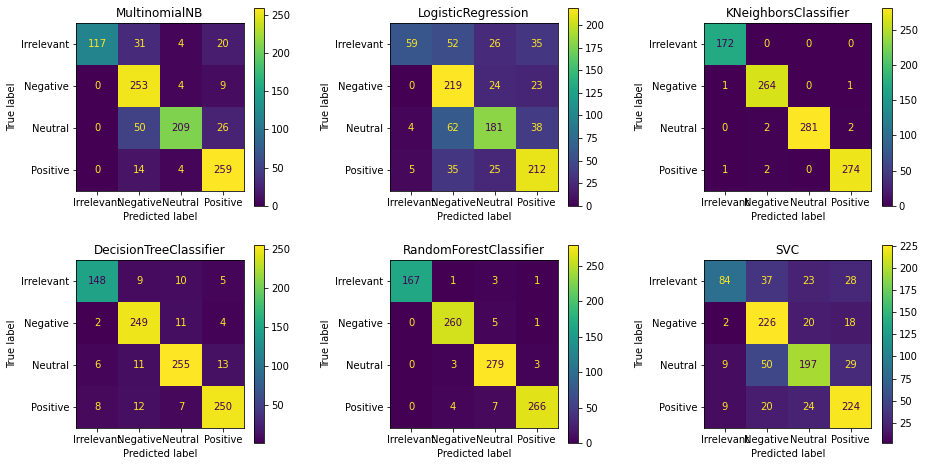

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
plt.subplots_adjust(wspace=0.5)
for i, (classifier_name, results_dict) in enumerate(confusion_matrix_displays.items()):
    row = i // 3
    col = i % 3

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, results_dict['predict']),
                                  display_labels=results_dict['classifier'].classes_)
    disp.plot(ax=axes[row, col])
    axes[row, col].set_title(classifier_name)

plt.show()
    

## Accuracy comparison

In [27]:
classifier_result = pd.DataFrame(classifier_accuracy,columns=["classifier","accuracy","accuracy on trainset"]).sort_values(by='accuracy',ascending=False)
classifier_result

,classifier,accuracy,accuracy on trainset
3,KNeighborsClassifier,0.991,0.961165
5,RandomForestClassifier,0.972,0.986172
0,1D Convolutional Neural Network,0.957,0.952054
4,DecisionTreeClassifier,0.902,0.959464
1,MultinomialNB,0.838,0.813417
6,SVC,0.731,0.702267
2,LogisticRegression,0.671,0.657821


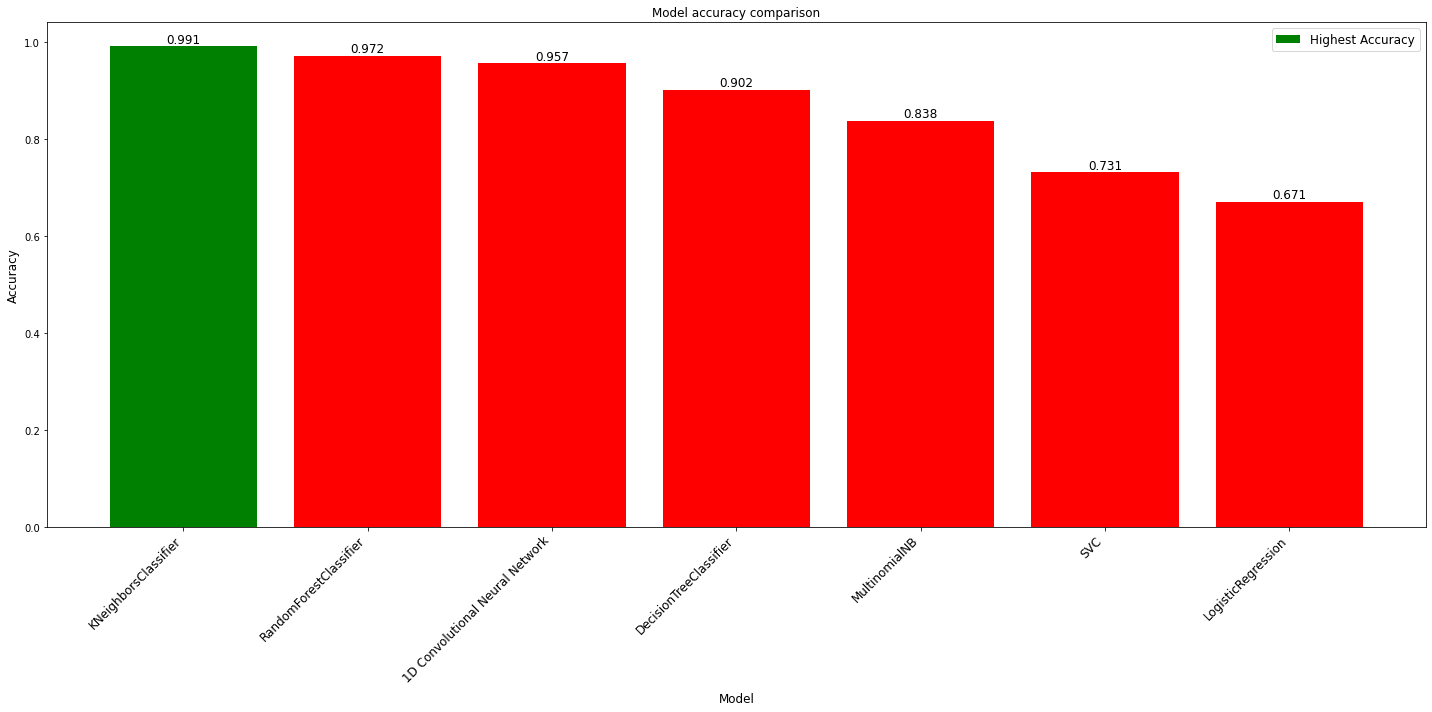

In [28]:
plt.figure(figsize=(20, 10))
highest_accuracy_index = classifier_result['accuracy'].idxmax()
desired_classifier=classifier_result.loc[highest_accuracy_index, 'classifier']
colors = ['green' if i == desired_classifier else 'red' for i in classifier_result['classifier']]
bars=plt.bar(classifier_result['classifier'], classifier_result['accuracy'], color=colors)
plt.xlabel('Model',fontsize='large')
plt.ylabel('Accuracy',fontsize='large')
plt.title('Model accuracy comparison',fontsize='large')
plt.xticks(rotation=45, ha='right',fontsize='large')
plt.legend( ['Highest Accuracy'], loc='upper right',fontsize='large')
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{classifier_result["accuracy"].iloc[i]:.3f}', ha='center', va='bottom', color='black',fontsize='large')
plt.tight_layout()

plt.show()